# Optuna Tuning | RandomForestClassifier
**RandomForestClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [159]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [160]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

### 0.2 Constants

In [161]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'rf' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

RANDOM_STATE = 38

### 0.3 Loading datasets

In [162]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling & Scoring Definition**
Applying scaling to numerical features, and defining the scoring function.

In [163]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [164]:
NUMERICAL_COLUMNS = [
    'time_in_hospital', 'age', 'num_lab_procedures',
    'num_diagnoses', 'num_inpatient'
]

In [165]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [166]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 37607, 1: 4441})
Test set: Counter({0: 16117, 1: 1904})


### 1.2 Scoring Function

In [167]:
scoring = 'f1_macro'

## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [168]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    f1_score = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [169]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-28 21:50:52,934] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [170]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-28 21:51:00,388] Trial 0 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:00,461] Trial 8 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:00,481] Trial 7 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:02,366] Trial 2 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:03,298] Trial 3 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:03,524] Trial 9 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 58}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:03,999] Trial 10 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:04,014] Trial 4 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 48}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:04,027] Trial 6 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 46}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:04,295] Trial 11 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 42}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:05,264] Trial 5 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:06,387] Trial 1 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-28 21:51:08,178] Trial 14 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:08,970] Trial 12 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 44}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:12,009] Trial 13 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:12,845] Trial 16 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 58}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:13,336] Trial 15 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:14,179] Trial 17 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:14,790] Trial 18 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 54}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:15,451] Trial 21 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 38}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:16,155] Trial 22 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 36}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:16,943] Trial 19 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:17,449] Trial 20 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:19,608] Trial 24 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:20,349] Trial 23 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.47258533151549786.
[I 2024-12-28 21:51:20,509] Trial 25 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:22,480] Trial 28 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 40}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:25,055] Trial 33 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:25,334] Trial 27 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 23 with value: 0.47258533151549786.
[I 2024-12-28 21:51:25,407] Trial 32 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:25,737] Trial 29 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 18}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:26,866] Trial 31 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 26}. Best is trial 23 with value: 0.47258533151549786.
[I 2024-12-28 21:51:26,997] Trial 26 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:51:27,523] Trial 34 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 26 with value: 0.473173424416047.
[I 2024-12-28 21:51:27,719] Trial 30 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:31,113] Trial 35 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:33,381] Trial 42 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 44}. Best is trial 26 with value: 0.473173424416047.
[I 2024-12-28 21:51:33,427] Trial 43 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 60}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:33,806] Trial 37 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716


[I 2024-12-28 21:51:35,015] Trial 36 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357


[I 2024-12-28 21:51:36,360] Trial 38 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:36,539] Trial 40 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 22}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:37,228] Trial 41 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:37,323] Trial 39 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:40,453] Trial 45 finished with value: 0.4725781979737643 and parameters: {'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-28 21:51:41,753] Trial 44 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:51:42,235] Trial 46 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357


[I 2024-12-28 21:51:43,023] Trial 47 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:44,931] Trial 49 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 16}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:45,996] Trial 48 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:46,857] Trial 50 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:46,933] Trial 51 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:50,097] Trial 52 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:51:50,599] Trial 54 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average F1-score: 0.4725781986740367


[I 2024-12-28 21:51:50,939] Trial 55 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:51:51,341] Trial 53 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:51:52,969] Trial 56 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:56,745] Trial 57 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:56,819] Trial 60 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:56,854] Trial 58 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357


[I 2024-12-28 21:51:57,865] Trial 59 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:58,030] Trial 61 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:59,876] Trial 62 finished with value: 0.4725781979737643 and parameters: {'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-28 21:52:01,504] Trial 63 finished with value: 0.47261655297780314 and parameters: {'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47368951 0.47270109 0.47266667 0.47259423 0.47143127]
Average F1-score: 0.47261655297780314


[I 2024-12-28 21:52:02,728] Trial 66 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:03,575] Trial 65 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:03,599] Trial 64 finished with value: 0.4725583163842101 and parameters: {'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average F1-score: 0.4725781986740367
Cross validation F1-scores: [0.47325166 0.47209842 0.47209842 0.47324816 0.47209492]
Average F1-score: 0.4725583163842101


[I 2024-12-28 21:52:05,256] Trial 68 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:05,897] Trial 67 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:08,584] Trial 71 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:10,782] Trial 73 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716


[I 2024-12-28 21:52:11,389] Trial 69 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:11,528] Trial 70 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047
Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:12,608] Trial 72 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:14,200] Trial 75 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-28 21:52:14,462] Trial 74 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784


[I 2024-12-28 21:52:15,030] Trial 76 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:17,006] Trial 77 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:17,206] Trial 79 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:18,183] Trial 78 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-28 21:52:18,541] Trial 80 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:22,022] Trial 81 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:24,874] Trial 85 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:25,069] Trial 84 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:25,436] Trial 82 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:25,993] Trial 83 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-28 21:52:26,989] Trial 88 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:27,986] Trial 87 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:52:28,615] Trial 86 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:28,660] Trial 90 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:29,495] Trial 89 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:30,454] Trial 91 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:32,038] Trial 92 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:34,258] Trial 93 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-28 21:52:34,947] Trial 99 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 34}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:35,276] Trial 95 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:35,331] Trial 96 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-28 21:52:35,508] Trial 94 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:35,897] Trial 97 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:52:37,373] Trial 98 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


In [171]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 36
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2}
Best Value: 0.4732872294982357


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [172]:
optuna.visualization.plot_optimization_history(study)

In [173]:
optuna.visualization.plot_slice(study)

In [174]:
optuna.visualization.plot_param_importances(study)

In [175]:
optuna.visualization.plot_parallel_coordinate(study)

In [176]:
optuna.visualization.plot_contour(study)

In [177]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [178]:
# Fit best model on the training set
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, random_state=38)

In [179]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [180]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9018740487062404
Test accuracy:  0.8935686143943178


In [181]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.89      1.00      0.94     16117
      Early-readmission       0.06      0.00      0.00      1904

               accuracy                           0.89     18021
              macro avg       0.48      0.50      0.47     18021
           weighted avg       0.81      0.89      0.84     18021



In [182]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

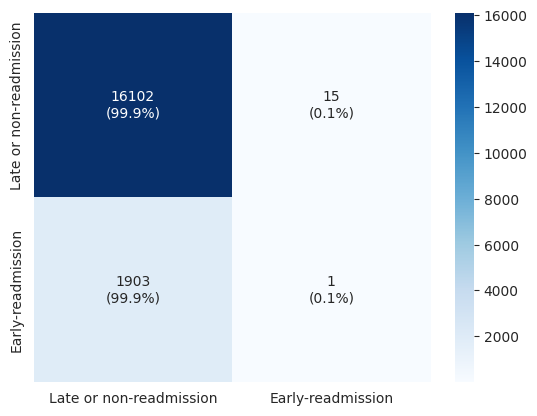

In [183]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [184]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=scoring)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [185]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-28 21:52:40,044] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [186]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-28 21:52:47,889] Trial 6 finished with value: 0.4847983425783208 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 6 with value: 0.4847983425783208.
[I 2024-12-28 21:52:48,017] Trial 9 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.47704766 0.47591803 0.48781896 0.48449493 0.49871213]
Average F1-score: 0.4847983425783208
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:52:48,232] Trial 10 finished with value: 0.48041554766073097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,335] Trial 7 finished with value: 0.47609601262958207 and parameters: {'max_depth': 6, 'min_samples_leaf': 60}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.4788587  0.48123752 0.47893053 0.47409882 0.48895217]
Average F1-score: 0.48041554766073097
Cross validation F1-scores: [0.47580253 0.47370454 0.47569498 0.47328385 0.48199416]
Average F1-score: 0.47609601262958207


[I 2024-12-28 21:52:48,493] Trial 3 finished with value: 0.47228557271788596 and parameters: {'max_depth': 18, 'min_samples_leaf': 48}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,496] Trial 2 finished with value: 0.47176678555115503 and parameters: {'max_depth': 28, 'min_samples_leaf': 44}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,577] Trial 5 finished with value: 0.4714257042614001 and parameters: {'max_depth': 10, 'min_samples_leaf': 38}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,631] Trial 4 finished with value: 0.4711661385981654 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.46901266 0.47202701 0.4720121  0.46882987 0.47954622]
Average F1-score: 0.47228557271788596
Cross validation F1-scores: [0.47435984 0.46872326 0.46966377 0.46630448 0.47978259]
Average F1-score: 0.47176678555115503
Cross validation F1-scores: [0.47283818 0.46813529 0.47054035 0.46529472 0.48031999]
Average F1-score: 0.4714257042614001
Cross validation F1-scores: [0.47030021 0.46923521 0.46868634 0.46979199 0.47781695]
Average F1-score: 0.4711661385981654
Cross validation F1-scores: [0.47122185 0.46686028 0.47134054 0.46919558 0.47890217]
Average F1-score: 0.4715040826996745


[I 2024-12-28 21:52:48,675] Trial 11 finished with value: 0.4715040826996745 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,821] Trial 8 finished with value: 0.4739607766823508 and parameters: {'max_depth': 18, 'min_samples_leaf': 26}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.47234163 0.47451175 0.47288345 0.47050561 0.47956144]
Average F1-score: 0.4739607766823508


[I 2024-12-28 21:52:49,216] Trial 1 finished with value: 0.470041334775118 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:49,404] Trial 0 finished with value: 0.46670826038752666 and parameters: {'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.46799906 0.46967146 0.46711968 0.46987071 0.47554577]
Average F1-score: 0.470041334775118
Cross validation F1-scores: [0.46300411 0.46984126 0.46181174 0.46746414 0.47142005]
Average F1-score: 0.46670826038752666


[I 2024-12-28 21:52:55,556] Trial 12 finished with value: 0.48539120037443084 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.47536809 0.4773856  0.49095311 0.48687438 0.49637483]
Average F1-score: 0.48539120037443084


[I 2024-12-28 21:52:56,188] Trial 17 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,273] Trial 13 finished with value: 0.4734343086367301 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323
Cross validation F1-scores: [0.47437593 0.46993567 0.47468615 0.46833624 0.47983754]
Average F1-score: 0.4734343086367301


[I 2024-12-28 21:52:56,648] Trial 15 finished with value: 0.4727475713628391 and parameters: {'max_depth': 20, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,700] Trial 18 finished with value: 0.4778343751528665 and parameters: {'max_depth': 6, 'min_samples_leaf': 46}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,701] Trial 14 finished with value: 0.4727475713628391 and parameters: {'max_depth': 28, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,784] Trial 16 finished with value: 0.4729892505584412 and parameters: {'max_depth': 24, 'min_samples_leaf': 50}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average F1-score: 0.4727475713628391
Cross validation F1-scores: [0.4758436  0.47192849 0.4791292  0.47709604 0.48517454]
Average F1-score: 0.4778343751528665
Cross validation F1-scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average F1-score: 0.4727475713628391
Cross validation F1-scores: [0.47363908 0.47058848 0.47395498 0.46645971 0.480304  ]
Average F1-score: 0.4729892505584412


[I 2024-12-28 21:52:57,154] Trial 19 finished with value: 0.4705960866616109 and parameters: {'max_depth': 12, 'min_samples_leaf': 36}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:57,255] Trial 20 finished with value: 0.47358997284134735 and parameters: {'max_depth': 8, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4700389  0.46988189 0.47056315 0.46640345 0.47609304]
Average F1-score: 0.4705960866616109
Cross validation F1-scores: [0.47261039 0.47641777 0.47153732 0.47121233 0.47617206]
Average F1-score: 0.47358997284134735


[I 2024-12-28 21:52:57,825] Trial 21 finished with value: 0.4710061475457653 and parameters: {'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:57,995] Trial 23 finished with value: 0.47342075797509553 and parameters: {'max_depth': 8, 'min_samples_leaf': 32}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46950009 0.46907559 0.46952927 0.46830707 0.47861872]
Average F1-score: 0.4710061475457653
Cross validation F1-scores: [0.47279192 0.47528148 0.47197158 0.47011617 0.47694263]
Average F1-score: 0.47342075797509553


[I 2024-12-28 21:52:58,137] Trial 22 finished with value: 0.4707415993579632 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47042679 0.46878441 0.46764477 0.46719887 0.47965316]
Average F1-score: 0.4707415993579632


[I 2024-12-28 21:53:03,778] Trial 25 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579


[I 2024-12-28 21:53:04,665] Trial 32 finished with value: 0.48539120037443084 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:04,784] Trial 26 finished with value: 0.47225691031770295 and parameters: {'max_depth': 14, 'min_samples_leaf': 32}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47536809 0.4773856  0.49095311 0.48687438 0.49637483]
Average F1-score: 0.48539120037443084
Cross validation F1-scores: [0.47281762 0.4725406  0.46759568 0.46862457 0.47970608]
Average F1-score: 0.47225691031770295


[I 2024-12-28 21:53:05,060] Trial 27 finished with value: 0.47403274368955134 and parameters: {'max_depth': 8, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,069] Trial 31 finished with value: 0.4733007516163754 and parameters: {'max_depth': 10, 'min_samples_leaf': 60}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,221] Trial 33 finished with value: 0.48533936718856385 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47369143 0.47393907 0.47313938 0.47195289 0.47744095]
Average F1-score: 0.47403274368955134
Cross validation F1-scores: [0.47572604 0.4683907  0.47562807 0.46829802 0.47846093]
Average F1-score: 0.4733007516163754
Cross validation F1-scores: [0.47703985 0.47797284 0.48858591 0.48650951 0.49658872]
Average F1-score: 0.48533936718856385


[I 2024-12-28 21:53:05,369] Trial 30 finished with value: 0.4715809335965909 and parameters: {'max_depth': 16, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.471272   0.47044024 0.46933129 0.4683504  0.47851075]
Average F1-score: 0.4715809335965909


[I 2024-12-28 21:53:05,699] Trial 28 finished with value: 0.46892445935736643 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,781] Trial 29 finished with value: 0.46892445935736643 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,870] Trial 34 finished with value: 0.4800104278255738 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46746808 0.47093293 0.46472612 0.46847854 0.47301662]
Average F1-score: 0.46892445935736643
Cross validation F1-scores: [0.46746808 0.47093293 0.46472612 0.46847854 0.47301662]
Average F1-score: 0.46892445935736643
Cross validation F1-scores: [0.47853363 0.48035518 0.47721801 0.47509551 0.48884981]
Average F1-score: 0.4800104278255738


[I 2024-12-28 21:53:05,989] Trial 24 finished with value: 0.4578616303710904 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.45122568 0.45792744 0.45692606 0.45812588 0.46510309]
Average F1-score: 0.4578616303710904


[I 2024-12-28 21:53:06,414] Trial 35 finished with value: 0.4742857945041017 and parameters: {'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47656186 0.47491024 0.47089343 0.47372075 0.47534269]
Average F1-score: 0.4742857945041017


[I 2024-12-28 21:53:12,560] Trial 36 finished with value: 0.4740827147119967 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4754445  0.46923521 0.47467655 0.47081617 0.48024115]
Average F1-score: 0.4740827147119967


[I 2024-12-28 21:53:13,222] Trial 38 finished with value: 0.4851639186873721 and parameters: {'max_depth': 4, 'min_samples_leaf': 42}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47513425 0.47611694 0.48434387 0.48459917 0.50562536]
Average F1-score: 0.4851639186873721


[I 2024-12-28 21:53:13,675] Trial 40 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:13,681] Trial 42 finished with value: 0.48550376342534723 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:13,687] Trial 37 finished with value: 0.47325598557818765 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:13,791] Trial 39 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]Cross validation F1-scores: [0.47704766 0.47675524 0.4872864  0.48582597 0.50060355]
Average F1-score: 0.48550376342534723

Average F1-score: 0.4761453529744292
Cross validation F1-scores: [0.47591601 0.47099888 0.47351853 0.46823554 0.47761097]
Average F1-score: 0.47325598557818765
Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average F1-score: 0.4761453529744292


[I 2024-12-28 21:53:14,234] Trial 43 finished with value: 0.4848160939105761 and parameters: {'max_depth': 4, 'min_samples_leaf': 34}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:14,359] Trial 46 finished with value: 0.48457051464930856 and parameters: {'max_depth': 4, 'min_samples_leaf': 38}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:14,398] Trial 41 finished with value: 0.47228557271788596 and parameters: {'max_depth': 24, 'min_samples_leaf': 48}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47549107 0.47888066 0.48395274 0.48340925 0.50234675]
Average F1-score: 0.4848160939105761
Cross validation F1-scores: [0.47494731 0.47734562 0.48216804 0.48468099 0.50371062]
Average F1-score: 0.48457051464930856
Cross validation F1-scores: [0.46901266 0.47202701 0.4720121  0.46882987 0.47954622]
Average F1-score: 0.47228557271788596


[I 2024-12-28 21:53:15,038] Trial 45 finished with value: 0.47803307902019254 and parameters: {'max_depth': 6, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:15,206] Trial 44 finished with value: 0.4733814010148528 and parameters: {'max_depth': 8, 'min_samples_leaf': 44}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47689889 0.47753816 0.47523126 0.47664892 0.48384816]
Average F1-score: 0.47803307902019254
Cross validation F1-scores: [0.47493007 0.4684036  0.47481238 0.47031744 0.47844351]
Average F1-score: 0.4733814010148528


[I 2024-12-28 21:53:15,954] Trial 47 finished with value: 0.4716935260262402 and parameters: {'max_depth': 10, 'min_samples_leaf': 24}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47178396 0.46989137 0.46866143 0.46962352 0.47850735]
Average F1-score: 0.4716935260262402


[I 2024-12-28 21:53:20,593] Trial 48 finished with value: 0.48529569032382697 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47382025 0.48058155 0.48627668 0.48352127 0.5022787 ]
Average F1-score: 0.48529569032382697


[I 2024-12-28 21:53:21,632] Trial 52 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:21,652] Trial 50 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:21,656] Trial 49 finished with value: 0.4714086766848274 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:21,711] Trial 51 finished with value: 0.48550376342534723 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202
Cross validation F1-scores: [0.47277595 0.46850643 0.46702099 0.46905069 0.47968932]
Average F1-score: 0.4714086766848274
Cross validation F1-scores: [0.47704766 0.47675524 0.4872864  0.48582597 0.50060355]
Average F1-score: 0.48550376342534723


[I 2024-12-28 21:53:22,261] Trial 53 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:22,446] Trial 55 finished with value: 0.4764687883341104 and parameters: {'max_depth': 6, 'min_samples_leaf': 36}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055
Cross validation F1-scores: [0.47293609 0.47514802 0.47919125 0.47454518 0.48052339]
Average F1-score: 0.4764687883341104


[I 2024-12-28 21:53:22,500] Trial 54 finished with value: 0.47775745406786774 and parameters: {'max_depth': 6, 'min_samples_leaf': 30}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47761647 0.47799661 0.4744792  0.47547381 0.48322118]
Average F1-score: 0.47775745406786774


[I 2024-12-28 21:53:23,238] Trial 56 finished with value: 0.4716935260262402 and parameters: {'max_depth': 10, 'min_samples_leaf': 24}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47178396 0.46989137 0.46866143 0.46962352 0.47850735]
Average F1-score: 0.4716935260262402


[I 2024-12-28 21:53:23,492] Trial 57 finished with value: 0.4733814010148528 and parameters: {'max_depth': 8, 'min_samples_leaf': 44}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47493007 0.4684036  0.47481238 0.47031744 0.47844351]
Average F1-score: 0.4733814010148528


[I 2024-12-28 21:53:24,021] Trial 59 finished with value: 0.4771830412636426 and parameters: {'max_depth': 6, 'min_samples_leaf': 48}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47580253 0.47359165 0.47609691 0.4740216  0.48640251]
Average F1-score: 0.4771830412636426


[I 2024-12-28 21:53:24,757] Trial 58 finished with value: 0.4686483273526056 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46497227 0.47141382 0.45992483 0.47207664 0.47485408]
Average F1-score: 0.4686483273526056


[I 2024-12-28 21:53:29,128] Trial 60 finished with value: 0.4721322989049989 and parameters: {'max_depth': 8, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46956481 0.46776302 0.47403054 0.4706594  0.47864373]
Average F1-score: 0.4721322989049989


[I 2024-12-28 21:53:29,631] Trial 63 finished with value: 0.48483762397488733 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:29,647] Trial 62 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:29,689] Trial 61 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47577651 0.47602617 0.49082707 0.48412584 0.49743252]
Average F1-score: 0.48483762397488733
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:30,101] Trial 64 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055


[I 2024-12-28 21:53:30,358] Trial 65 finished with value: 0.4846995112610957 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47640847 0.47740408 0.48904633 0.4839714  0.49666728]
Average F1-score: 0.4846995112610957


[I 2024-12-28 21:53:30,864] Trial 66 finished with value: 0.4769412234116646 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4747329  0.47521447 0.47458873 0.47694883 0.48322118]
Average F1-score: 0.4769412234116646


[I 2024-12-28 21:53:31,389] Trial 68 finished with value: 0.4847983425783208 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47704766 0.47591803 0.48781896 0.48449493 0.49871213]
Average F1-score: 0.4847983425783208


[I 2024-12-28 21:53:32,027] Trial 67 finished with value: 0.47032796137438754 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46912559 0.46942588 0.46639415 0.47067871 0.47601547]
Average F1-score: 0.47032796137438754


[I 2024-12-28 21:53:32,609] Trial 69 finished with value: 0.4698880560221883 and parameters: {'max_depth': 10, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47097446 0.46622996 0.4675859  0.46722239 0.47742757]
Average F1-score: 0.4698880560221883


[I 2024-12-28 21:53:32,909] Trial 70 finished with value: 0.4731511208691682 and parameters: {'max_depth': 8, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47451709 0.4712962  0.47080296 0.47218289 0.47695647]
Average F1-score: 0.4731511208691682


[I 2024-12-28 21:53:33,284] Trial 71 finished with value: 0.4786026030169784 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4768307  0.47744566 0.47875422 0.47568609 0.48429634]
Average F1-score: 0.4786026030169784


[I 2024-12-28 21:53:37,449] Trial 72 finished with value: 0.48550376342534723 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47704766 0.47675524 0.4872864  0.48582597 0.50060355]
Average F1-score: 0.48550376342534723


[I 2024-12-28 21:53:37,944] Trial 74 finished with value: 0.48483762397488733 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:38,005] Trial 73 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47577651 0.47602617 0.49082707 0.48412584 0.49743252]
Average F1-score: 0.48483762397488733
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:38,384] Trial 76 finished with value: 0.4862940497360452 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:38,502] Trial 75 finished with value: 0.4800104278255738 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47703174 0.47692802 0.49020532 0.48635489 0.50095027]
Average F1-score: 0.4862940497360452
Cross validation F1-scores: [0.47853363 0.48035518 0.47721801 0.47509551 0.48884981]
Average F1-score: 0.4800104278255738


[I 2024-12-28 21:53:39,549] Trial 79 finished with value: 0.48394571982031265 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47618324 0.47723642 0.48741166 0.48387172 0.49502556]
Average F1-score: 0.48394571982031265


[I 2024-12-28 21:53:39,981] Trial 77 finished with value: 0.4693494345770026 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:40,076] Trial 78 finished with value: 0.47216663316582935 and parameters: {'max_depth': 26, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46703595 0.4699694  0.46492102 0.46945738 0.47536342]
Average F1-score: 0.4693494345770026
Cross validation F1-scores: [0.47055149 0.46733239 0.46989364 0.46954077 0.48351488]
Average F1-score: 0.47216663316582935


[I 2024-12-28 21:53:40,522] Trial 80 finished with value: 0.4787527112478365 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47832138 0.47963429 0.47589576 0.47617058 0.48374154]
Average F1-score: 0.4787527112478365


[I 2024-12-28 21:53:40,874] Trial 82 finished with value: 0.48483762397488733 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:41,027] Trial 81 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47577651 0.47602617 0.49082707 0.48412584 0.49743252]
Average F1-score: 0.48483762397488733
Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055


[I 2024-12-28 21:53:41,314] Trial 83 finished with value: 0.4861918069362554 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47509353 0.47644401 0.4909235  0.48627088 0.50222711]
Average F1-score: 0.4861918069362554


[I 2024-12-28 21:53:45,676] Trial 84 finished with value: 0.486241487421918 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47735144 0.47756834 0.48926709 0.48526677 0.5017538 ]
Average F1-score: 0.486241487421918


[I 2024-12-28 21:53:46,252] Trial 86 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:46,769] Trial 85 finished with value: 0.473177010753653 and parameters: {'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47546082 0.47081797 0.47248048 0.47138386 0.47574193]
Average F1-score: 0.473177010753653


[I 2024-12-28 21:53:47,139] Trial 87 finished with value: 0.47939262870337923 and parameters: {'max_depth': 6, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.476141   0.47831452 0.48000873 0.47649124 0.48600766]
Average F1-score: 0.47939262870337923


[I 2024-12-28 21:53:47,801] Trial 88 finished with value: 0.47246743107040584 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46878438 0.47421906 0.47275181 0.47110096 0.47548095]
Average F1-score: 0.47246743107040584


[I 2024-12-28 21:53:48,026] Trial 89 finished with value: 0.4862940497360452 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47703174 0.47692802 0.49020532 0.48635489 0.50095027]
Average F1-score: 0.4862940497360452


[I 2024-12-28 21:53:48,522] Trial 90 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579


[I 2024-12-28 21:53:48,771] Trial 91 finished with value: 0.4786026030169784 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:48,848] Trial 92 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4768307  0.47744566 0.47875422 0.47568609 0.48429634]
Average F1-score: 0.4786026030169784
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:49,081] Trial 94 finished with value: 0.48529569032382697 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:49,123] Trial 95 finished with value: 0.4861918069362554 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:49,141] Trial 93 finished with value: 0.4787527112478365 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47382025 0.48058155 0.48627668 0.48352127 0.5022787 ]
Average F1-score: 0.48529569032382697
Cross validation F1-scores: [0.47509353 0.47644401 0.4909235  0.48627088 0.50222711]
Average F1-score: 0.4861918069362554
Cross validation F1-scores: [0.47832138 0.47963429 0.47589576 0.47617058 0.48374154]
Average F1-score: 0.4787527112478365


[I 2024-12-28 21:53:50,177] Trial 97 finished with value: 0.48533936718856385 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:50,190] Trial 96 finished with value: 0.47928702987994576 and parameters: {'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:50,256] Trial 99 finished with value: 0.486241487421918 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:50,351] Trial 98 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47703985 0.47797284 0.48858591 0.48650951 0.49658872]
Average F1-score: 0.48533936718856385
Cross validation F1-scores: [0.47832357 0.47857492 0.47770407 0.47896331 0.48286926]
Average F1-score: 0.47928702987994576
Cross validation F1-scores: [0.47735144 0.47756834 0.48926709 0.48526677 0.5017538 ]
Average F1-score: 0.486241487421918
Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055


In [187]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 17
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 50}
Best Value: 0.48664376312535323


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [188]:
optuna.visualization.plot_optimization_history(study)

In [189]:
optuna.visualization.plot_slice(study)

In [190]:
optuna.visualization.plot_param_importances(study)

In [191]:
optuna.visualization.plot_parallel_coordinate(study)

In [192]:
optuna.visualization.plot_contour(study)

In [193]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [194]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=50,
                                        random_state=38))])

In [195]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [196]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6238584474885844
Test accuracy:  0.6204983075301038


In [197]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.63      0.75     16117
      Early-readmission       0.15      0.56      0.24      1904

               accuracy                           0.62     18021
              macro avg       0.54      0.59      0.49     18021
           weighted avg       0.84      0.62      0.69     18021



In [198]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

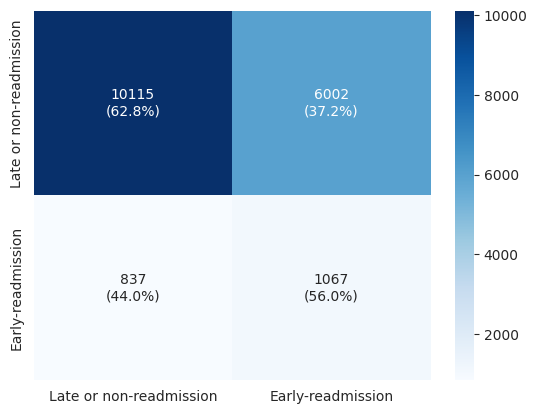

In [199]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [200]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=scoring)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [201]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-28 21:53:51,235] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [202]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-28 21:54:06,661] Trial 8 finished with value: 0.5026115724632253 and parameters: {'max_depth': 6, 'min_samples_leaf': 56}. Best is trial 8 with value: 0.5026115724632253.
[I 2024-12-28 21:54:06,740] Trial 10 finished with value: 0.5038128740474462 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 10 with value: 0.5038128740474462.


Cross validation F1-scores: [0.50306229 0.49330388 0.50182876 0.50077705 0.51408588]
Average F1-score: 0.5026115724632253
Cross validation F1-scores: [0.50281787 0.49382584 0.50258138 0.50318237 0.51665691]
Average F1-score: 0.5038128740474462


[I 2024-12-28 21:54:09,499] Trial 9 finished with value: 0.5173821942658895 and parameters: {'max_depth': 8, 'min_samples_leaf': 34}. Best is trial 9 with value: 0.5173821942658895.


Cross validation F1-scores: [0.51806086 0.51627786 0.51457866 0.51150942 0.52648417]
Average F1-score: 0.5173821942658895


[I 2024-12-28 21:54:12,381] Trial 7 finished with value: 0.5293115549239108 and parameters: {'max_depth': 10, 'min_samples_leaf': 38}. Best is trial 7 with value: 0.5293115549239108.


Cross validation F1-scores: [0.52770813 0.53011847 0.52405742 0.52142401 0.54324975]
Average F1-score: 0.5293115549239108


[I 2024-12-28 21:54:14,830] Trial 2 finished with value: 0.5331659355720024 and parameters: {'max_depth': 12, 'min_samples_leaf': 18}. Best is trial 2 with value: 0.5331659355720024.


Cross validation F1-scores: [0.53008674 0.52538182 0.53487313 0.53196392 0.54352407]
Average F1-score: 0.5331659355720024


[I 2024-12-28 21:54:16,145] Trial 5 finished with value: 0.5373062115052117 and parameters: {'max_depth': 14, 'min_samples_leaf': 38}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.53489593 0.52905622 0.54226584 0.53321309 0.54709998]
Average F1-score: 0.5373062115052117


[I 2024-12-28 21:54:18,016] Trial 3 finished with value: 0.5354427276010805 and parameters: {'max_depth': 24, 'min_samples_leaf': 40}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.52752893 0.52812877 0.54627992 0.53641956 0.53885646]
Average F1-score: 0.5354427276010805


[I 2024-12-28 21:54:18,233] Trial 4 finished with value: 0.5363816335078692 and parameters: {'max_depth': 16, 'min_samples_leaf': 16}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.52917159 0.53725578 0.54273533 0.5356854  0.53706007]
Average F1-score: 0.5363816335078692


[I 2024-12-28 21:54:18,936] Trial 0 finished with value: 0.5339966744089951 and parameters: {'max_depth': 28, 'min_samples_leaf': 30}. Best is trial 5 with value: 0.5373062115052117.
[I 2024-12-28 21:54:18,943] Trial 11 finished with value: 0.5348547121104603 and parameters: {'max_depth': 26, 'min_samples_leaf': 38}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.52436772 0.52812823 0.54593171 0.53318441 0.5383713 ]
Average F1-score: 0.5339966744089951
Cross validation F1-scores: [0.52566683 0.53142206 0.53933962 0.5385738  0.53927126]
Average F1-score: 0.5348547121104603


[I 2024-12-28 21:54:20,519] Trial 6 finished with value: 0.5234966724188512 and parameters: {'max_depth': 26, 'min_samples_leaf': 16}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.51277486 0.52299133 0.53116253 0.5219396  0.52861504]
Average F1-score: 0.5234966724188512


[I 2024-12-28 21:54:21,205] Trial 14 finished with value: 0.49021527834819156 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.49033828 0.48866658 0.49602685 0.4887424  0.48730228]
Average F1-score: 0.49021527834819156


[I 2024-12-28 21:54:23,584] Trial 1 finished with value: 0.513284603757366 and parameters: {'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.51104908 0.5089219  0.51987818 0.51492371 0.51165015]
Average F1-score: 0.513284603757366


[I 2024-12-28 21:54:33,348] Trial 13 finished with value: 0.5347535558323349 and parameters: {'max_depth': 16, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.53028598 0.5290665  0.54053294 0.53409058 0.53979178]
Average F1-score: 0.5347535558323349


[I 2024-12-28 21:54:38,836] Trial 12 finished with value: 0.513284603757366 and parameters: {'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.51104908 0.5089219  0.51987818 0.51492371 0.51165015]
Average F1-score: 0.513284603757366


[I 2024-12-28 21:54:40,585] Trial 17 finished with value: 0.5361185326663536 and parameters: {'max_depth': 14, 'min_samples_leaf': 44}. Best is trial 5 with value: 0.5373062115052117.


Cross validation F1-scores: [0.53401182 0.52718638 0.53873526 0.53510002 0.54555918]
Average F1-score: 0.5361185326663536


[I 2024-12-28 21:54:40,871] Trial 16 finished with value: 0.5380155017495084 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.53082696 0.53319128 0.5460888  0.5401787  0.53979178]
Average F1-score: 0.5380155017495084


[I 2024-12-28 21:54:42,675] Trial 18 finished with value: 0.5365582840660437 and parameters: {'max_depth': 14, 'min_samples_leaf': 30}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.5346608  0.53174192 0.53667001 0.5337426  0.5459761 ]
Average F1-score: 0.5365582840660437


[I 2024-12-28 21:54:43,785] Trial 19 finished with value: 0.5367669386425277 and parameters: {'max_depth': 18, 'min_samples_leaf': 54}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.53154328 0.53005225 0.540581   0.5355606  0.54609756]
Average F1-score: 0.5367669386425277


[I 2024-12-28 21:54:44,721] Trial 23 finished with value: 0.5332765661679066 and parameters: {'max_depth': 12, 'min_samples_leaf': 12}. Best is trial 16 with value: 0.5380155017495084.
[I 2024-12-28 21:54:44,916] Trial 20 finished with value: 0.5362552115486398 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52796166 0.52688081 0.53087739 0.53341004 0.54725292]
Average F1-score: 0.5332765661679066
Cross validation F1-scores: [0.53101745 0.53313489 0.54237237 0.53390382 0.54084752]
Average F1-score: 0.5362552115486398


[I 2024-12-28 21:54:46,832] Trial 21 finished with value: 0.5345516449448907 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52227972 0.53088843 0.54647174 0.53218913 0.5409292 ]
Average F1-score: 0.5345516449448907


[I 2024-12-28 21:54:47,116] Trial 15 finished with value: 0.5066517664664809 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.50755708 0.50088036 0.5129488  0.501975   0.50989758]
Average F1-score: 0.5066517664664809


[I 2024-12-28 21:54:48,094] Trial 22 finished with value: 0.5345516449448907 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52227972 0.53088843 0.54647174 0.53218913 0.5409292 ]
Average F1-score: 0.5345516449448907


[I 2024-12-28 21:54:49,945] Trial 24 finished with value: 0.5353192698128335 and parameters: {'max_depth': 16, 'min_samples_leaf': 24}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52702394 0.53104462 0.54014386 0.53533239 0.54305153]
Average F1-score: 0.5353192698128335


[I 2024-12-28 21:54:54,790] Trial 25 finished with value: 0.530378772446552 and parameters: {'max_depth': 10, 'min_samples_leaf': 12}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52579892 0.52903176 0.52667123 0.52739167 0.54300029]
Average F1-score: 0.530378772446552


[I 2024-12-28 21:55:04,965] Trial 26 finished with value: 0.5360957298009581 and parameters: {'max_depth': 18, 'min_samples_leaf': 48}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52638647 0.52717618 0.54252716 0.5339372  0.55045164]
Average F1-score: 0.5360957298009581


[I 2024-12-28 21:55:07,205] Trial 28 finished with value: 0.536961421739824 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52896337 0.53395844 0.54458786 0.53370359 0.54359384]
Average F1-score: 0.536961421739824


[I 2024-12-28 21:55:07,903] Trial 27 finished with value: 0.5334128489022706 and parameters: {'max_depth': 22, 'min_samples_leaf': 34}. Best is trial 16 with value: 0.5380155017495084.


Cross validation F1-scores: [0.52737688 0.52856109 0.54435345 0.53006641 0.53670641]
Average F1-score: 0.5334128489022706


[I 2024-12-28 21:55:08,199] Trial 29 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:55:09,015] Trial 31 finished with value: 0.5360710265754307 and parameters: {'max_depth': 14, 'min_samples_leaf': 50}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.53061775 0.53258075 0.53911143 0.53376557 0.54427964]
Average F1-score: 0.5360710265754307


[I 2024-12-28 21:55:09,807] Trial 34 finished with value: 0.5324272290925421 and parameters: {'max_depth': 12, 'min_samples_leaf': 58}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.52882217 0.52802967 0.53023874 0.5299889  0.54505666]
Average F1-score: 0.5324272290925421


[I 2024-12-28 21:55:10,222] Trial 32 finished with value: 0.5384549438130473 and parameters: {'max_depth': 18, 'min_samples_leaf': 60}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.534893   0.5338727  0.54254585 0.53545376 0.54550941]
Average F1-score: 0.5384549438130473


[I 2024-12-28 21:55:10,858] Trial 30 finished with value: 0.5373615583238858 and parameters: {'max_depth': 24, 'min_samples_leaf': 42}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.52714956 0.53326954 0.54854761 0.53482815 0.54301293]
Average F1-score: 0.5373615583238858


[I 2024-12-28 21:55:13,187] Trial 33 finished with value: 0.53735774068596 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.53214638 0.5307792  0.54569032 0.53509248 0.54308031]
Average F1-score: 0.53735774068596


[I 2024-12-28 21:55:13,498] Trial 35 finished with value: 0.5360150675699844 and parameters: {'max_depth': 18, 'min_samples_leaf': 52}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.52886723 0.52895999 0.54403679 0.53728218 0.54092915]
Average F1-score: 0.5360150675699844


[I 2024-12-28 21:55:16,488] Trial 36 finished with value: 0.5375421370544893 and parameters: {'max_depth': 28, 'min_samples_leaf': 46}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.52871214 0.53357893 0.54772132 0.53372091 0.54397739]
Average F1-score: 0.5375421370544893


[I 2024-12-28 21:55:20,741] Trial 37 finished with value: 0.5362452407828657 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.53020539 0.52931497 0.54451006 0.53460951 0.54258627]
Average F1-score: 0.5362452407828657


[I 2024-12-28 21:55:26,188] Trial 38 finished with value: 0.528874339445123 and parameters: {'max_depth': 10, 'min_samples_leaf': 40}. Best is trial 29 with value: 0.5388276917946022.


Cross validation F1-scores: [0.52639991 0.52715695 0.52128082 0.52626524 0.54326878]
Average F1-score: 0.528874339445123


[I 2024-12-28 21:55:33,585] Trial 41 finished with value: 0.5394218510876956 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:55:33,634] Trial 39 finished with value: 0.536961421739824 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956
Cross validation F1-scores: [0.52896337 0.53395844 0.54458786 0.53370359 0.54359384]
Average F1-score: 0.536961421739824


[I 2024-12-28 21:55:34,810] Trial 42 finished with value: 0.5380155017495084 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53082696 0.53319128 0.5460888  0.5401787  0.53979178]
Average F1-score: 0.5380155017495084


[I 2024-12-28 21:55:35,492] Trial 40 finished with value: 0.5342717754770494 and parameters: {'max_depth': 26, 'min_samples_leaf': 36}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53131544 0.53018027 0.54132767 0.5299944  0.5385411 ]
Average F1-score: 0.5342717754770494


[I 2024-12-28 21:55:36,096] Trial 43 finished with value: 0.5375555537221663 and parameters: {'max_depth': 28, 'min_samples_leaf': 52}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:55:36,101] Trial 44 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.5281533  0.52824335 0.5471872  0.54139398 0.54279994]
Average F1-score: 0.5375555537221663
Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:55:37,632] Trial 45 finished with value: 0.5373615583238858 and parameters: {'max_depth': 24, 'min_samples_leaf': 42}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52714956 0.53326954 0.54854761 0.53482815 0.54301293]
Average F1-score: 0.5373615583238858


[I 2024-12-28 21:55:39,316] Trial 46 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:55:39,594] Trial 47 finished with value: 0.5362415311034089 and parameters: {'max_depth': 30, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52995752 0.52860096 0.54329765 0.53337629 0.54597522]
Average F1-score: 0.5362415311034089


[I 2024-12-28 21:55:43,414] Trial 48 finished with value: 0.5375421370544893 and parameters: {'max_depth': 28, 'min_samples_leaf': 46}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52871214 0.53357893 0.54772132 0.53372091 0.54397739]
Average F1-score: 0.5375421370544893


[I 2024-12-28 21:55:46,792] Trial 49 finished with value: 0.5387313417412866 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53057461 0.53277311 0.54596218 0.54025275 0.54409407]
Average F1-score: 0.5387313417412866


[I 2024-12-28 21:55:52,960] Trial 50 finished with value: 0.5372166379546355 and parameters: {'max_depth': 30, 'min_samples_leaf': 46}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52920563 0.53314444 0.54601889 0.53347272 0.54424151]
Average F1-score: 0.5372166379546355


[I 2024-12-28 21:55:55,065] Trial 60 finished with value: 0.4893460392053477 and parameters: {'max_depth': 4, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.49049504 0.47577508 0.4977443  0.49066394 0.49205184]
Average F1-score: 0.4893460392053477


[I 2024-12-28 21:55:59,268] Trial 51 finished with value: 0.5394218510876956 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956


[I 2024-12-28 21:55:59,803] Trial 52 finished with value: 0.5367636311584504 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53126325 0.52884101 0.54401753 0.53436215 0.54533423]
Average F1-score: 0.5367636311584504


[I 2024-12-28 21:56:00,754] Trial 53 finished with value: 0.5387313417412866 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53057461 0.53277311 0.54596218 0.54025275 0.54409407]
Average F1-score: 0.5387313417412866


[I 2024-12-28 21:56:01,262] Trial 54 finished with value: 0.5389120152142165 and parameters: {'max_depth': 24, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53358109 0.53586458 0.54257808 0.53654523 0.54599111]
Average F1-score: 0.5389120152142165


[I 2024-12-28 21:56:01,928] Trial 55 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:56:02,187] Trial 56 finished with value: 0.5372648745936635 and parameters: {'max_depth': 28, 'min_samples_leaf': 54}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53077736 0.53514191 0.54268783 0.5364394  0.54127787]
Average F1-score: 0.5372648745936635


[I 2024-12-28 21:56:03,678] Trial 57 finished with value: 0.5378236145106612 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.5281533  0.5291616  0.54710019 0.54139398 0.54330901]
Average F1-score: 0.5378236145106612


[I 2024-12-28 21:56:05,202] Trial 58 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:56:05,618] Trial 59 finished with value: 0.5362415311034089 and parameters: {'max_depth': 30, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52995752 0.52860096 0.54329765 0.53337629 0.54597522]
Average F1-score: 0.5362415311034089


[I 2024-12-28 21:56:12,982] Trial 61 finished with value: 0.5374904207794714 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53206508 0.53387894 0.54443224 0.53493754 0.54213831]
Average F1-score: 0.5374904207794714


[I 2024-12-28 21:56:18,892] Trial 62 finished with value: 0.5384692039544465 and parameters: {'max_depth': 28, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53105832 0.53470072 0.54543051 0.54008241 0.54107405]
Average F1-score: 0.5384692039544465


[I 2024-12-28 21:56:20,876] Trial 63 finished with value: 0.5394218510876956 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956


[I 2024-12-28 21:56:24,953] Trial 64 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012


[I 2024-12-28 21:56:26,325] Trial 65 finished with value: 0.5375555537221663 and parameters: {'max_depth': 28, 'min_samples_leaf': 52}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.5281533  0.52824335 0.5471872  0.54139398 0.54279994]
Average F1-score: 0.5375555537221663


[I 2024-12-28 21:56:26,936] Trial 66 finished with value: 0.5367636311584504 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53126325 0.52884101 0.54401753 0.53436215 0.54533423]
Average F1-score: 0.5367636311584504


[I 2024-12-28 21:56:27,633] Trial 67 finished with value: 0.53597998670316 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53002057 0.52840708 0.54471099 0.5351469  0.54161441]
Average F1-score: 0.53597998670316


[I 2024-12-28 21:56:27,966] Trial 69 finished with value: 0.5394218510876956 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956


[I 2024-12-28 21:56:29,823] Trial 70 finished with value: 0.5372648745936635 and parameters: {'max_depth': 28, 'min_samples_leaf': 54}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53077736 0.53514191 0.54268783 0.5364394  0.54127787]
Average F1-score: 0.5372648745936635


[I 2024-12-28 21:56:30,110] Trial 68 finished with value: 0.5342432630414342 and parameters: {'max_depth': 28, 'min_samples_leaf': 28}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52516573 0.52665994 0.54598624 0.5344704  0.538934  ]
Average F1-score: 0.5342432630414342


[I 2024-12-28 21:56:31,592] Trial 72 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:56:31,836] Trial 71 finished with value: 0.5371697221793561 and parameters: {'max_depth': 30, 'min_samples_leaf': 50}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52576499 0.5357625  0.54406392 0.53677412 0.54348309]
Average F1-score: 0.5371697221793561


[I 2024-12-28 21:56:38,808] Trial 73 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022


[I 2024-12-28 21:56:45,035] Trial 74 finished with value: 0.5367636311584504 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53126325 0.52884101 0.54401753 0.53436215 0.54533423]
Average F1-score: 0.5367636311584504


[I 2024-12-28 21:56:46,793] Trial 75 finished with value: 0.5394218510876956 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956


[I 2024-12-28 21:56:50,807] Trial 76 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012


[I 2024-12-28 21:56:52,476] Trial 77 finished with value: 0.537363774531126 and parameters: {'max_depth': 30, 'min_samples_leaf': 54}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53125903 0.53481166 0.54260219 0.53652299 0.54162301]
Average F1-score: 0.537363774531126


[I 2024-12-28 21:56:52,804] Trial 78 finished with value: 0.5362452407828657 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53020539 0.52931497 0.54451006 0.53460951 0.54258627]
Average F1-score: 0.5362452407828657


[I 2024-12-28 21:56:53,755] Trial 79 finished with value: 0.5375555537221663 and parameters: {'max_depth': 28, 'min_samples_leaf': 52}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:56:53,938] Trial 80 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.5281533  0.52824335 0.5471872  0.54139398 0.54279994]
Average F1-score: 0.5375555537221663
Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012


[I 2024-12-28 21:56:56,000] Trial 82 finished with value: 0.5394218510876956 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:56:56,174] Trial 81 finished with value: 0.53597998670316 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53565698 0.54434388 0.53835662 0.54513064]
Average F1-score: 0.5394218510876956
Cross validation F1-scores: [0.53002057 0.52840708 0.54471099 0.5351469  0.54161441]
Average F1-score: 0.53597998670316


[I 2024-12-28 21:56:57,457] Trial 83 finished with value: 0.5393528634310936 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53437154 0.54607752 0.53785238 0.54484174]
Average F1-score: 0.5393528634310936


[I 2024-12-28 21:56:58,124] Trial 84 finished with value: 0.5367987593476093 and parameters: {'max_depth': 28, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53004434 0.52951371 0.54425172 0.53403254 0.54615148]
Average F1-score: 0.5367987593476093


[I 2024-12-28 21:57:04,680] Trial 85 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012


[I 2024-12-28 21:57:10,623] Trial 86 finished with value: 0.5389120152142165 and parameters: {'max_depth': 24, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53358109 0.53586458 0.54257808 0.53654523 0.54599111]
Average F1-score: 0.5389120152142165


[I 2024-12-28 21:57:12,772] Trial 87 finished with value: 0.537363774531126 and parameters: {'max_depth': 30, 'min_samples_leaf': 54}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53125903 0.53481166 0.54260219 0.53652299 0.54162301]
Average F1-score: 0.537363774531126


[I 2024-12-28 21:57:18,232] Trial 90 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:57:18,236] Trial 89 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022
Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012


[I 2024-12-28 21:57:19,270] Trial 92 finished with value: 0.5388276917946022 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:57:19,391] Trial 91 finished with value: 0.5374904207794714 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53323427 0.53357885 0.54425839 0.53793632 0.54513064]
Average F1-score: 0.5388276917946022
Cross validation F1-scores: [0.53206508 0.53387894 0.54443224 0.53493754 0.54213831]
Average F1-score: 0.5374904207794714


[I 2024-12-28 21:57:21,322] Trial 94 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.
[I 2024-12-28 21:57:21,459] Trial 93 finished with value: 0.5362415311034089 and parameters: {'max_depth': 30, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012
Cross validation F1-scores: [0.52995752 0.52860096 0.54329765 0.53337629 0.54597522]
Average F1-score: 0.5362415311034089


[I 2024-12-28 21:57:22,090] Trial 95 finished with value: 0.5393528634310936 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53362113 0.53437154 0.54607752 0.53785238 0.54484174]
Average F1-score: 0.5393528634310936


[I 2024-12-28 21:57:22,366] Trial 88 finished with value: 0.513284603757366 and parameters: {'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.51104908 0.5089219  0.51987818 0.51492371 0.51165015]
Average F1-score: 0.513284603757366


[I 2024-12-28 21:57:24,640] Trial 96 finished with value: 0.5283421403926802 and parameters: {'max_depth': 30, 'min_samples_leaf': 20}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.52144515 0.52139813 0.53922186 0.52799028 0.53165529]
Average F1-score: 0.5283421403926802


[I 2024-12-28 21:57:26,745] Trial 97 finished with value: 0.5379926271964012 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53113907 0.53341513 0.54425172 0.53999731 0.5411599 ]
Average F1-score: 0.5379926271964012


[I 2024-12-28 21:57:29,807] Trial 98 finished with value: 0.5393913742642656 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53376171 0.53394487 0.547803   0.53583338 0.54561391]
Average F1-score: 0.5393913742642656


[I 2024-12-28 21:57:31,545] Trial 99 finished with value: 0.5362452407828657 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 41 with value: 0.5394218510876956.


Cross validation F1-scores: [0.53020539 0.52931497 0.54451006 0.53460951 0.54258627]
Average F1-score: 0.5362452407828657


In [203]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 41
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 60}
Best Value: 0.5394218510876956


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [204]:
optuna.visualization.plot_optimization_history(study)

In [205]:
optuna.visualization.plot_slice(study)

In [206]:
optuna.visualization.plot_param_importances(study)

In [207]:
optuna.visualization.plot_parallel_coordinate(study)

In [208]:
optuna.visualization.plot_contour(study)

In [209]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [210]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=60,
                                        random_state=38))])

In [211]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [212]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8193968797564688
Test accuracy:  0.797624993063648


In [213]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.86      0.88     16117
      Early-readmission       0.17      0.24      0.20      1904

               accuracy                           0.80     18021
              macro avg       0.54      0.55      0.54     18021
           weighted avg       0.83      0.80      0.81     18021



In [214]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

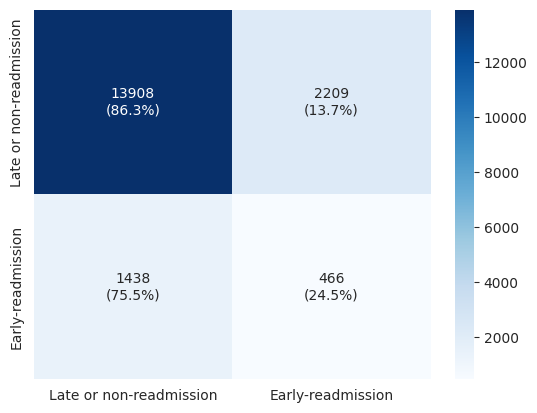

In [215]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [216]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=scoring)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [217]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-28 21:57:36,504] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [218]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-28 21:58:10,552] Trial 0 finished with value: 0.510687742630693 and parameters: {'max_depth': 8, 'min_samples_leaf': 52}. Best is trial 0 with value: 0.510687742630693.


Cross validation F1-scores: [0.5136495  0.50105442 0.50730065 0.51112742 0.52030672]
Average F1-score: 0.510687742630693


[I 2024-12-28 21:58:14,061] Trial 11 finished with value: 0.5216503583461518 and parameters: {'max_depth': 10, 'min_samples_leaf': 26}. Best is trial 11 with value: 0.5216503583461518.


Cross validation F1-scores: [0.52223541 0.51616765 0.51817421 0.51906672 0.5326078 ]
Average F1-score: 0.5216503583461518


[I 2024-12-28 21:58:17,139] Trial 8 finished with value: 0.5303166011663771 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 8 with value: 0.5303166011663771.


Cross validation F1-scores: [0.5281614  0.52373168 0.5285804  0.52765447 0.54345507]
Average F1-score: 0.5303166011663771


[I 2024-12-28 21:58:18,879] Trial 10 finished with value: 0.5322226959075504 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 10 with value: 0.5322226959075504.


Cross validation F1-scores: [0.52762755 0.52460388 0.53005785 0.53256559 0.54625861]
Average F1-score: 0.5322226959075504


[I 2024-12-28 21:58:19,899] Trial 6 finished with value: 0.5351464955909743 and parameters: {'max_depth': 16, 'min_samples_leaf': 40}. Best is trial 6 with value: 0.5351464955909743.
[I 2024-12-28 21:58:19,955] Trial 4 finished with value: 0.5326673522976917 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 6 with value: 0.5351464955909743.


Cross validation F1-scores: [0.52727456 0.53035944 0.5382881  0.5331364  0.54667397]
Average F1-score: 0.5351464955909743
Cross validation F1-scores: [0.52631396 0.52772996 0.53920199 0.53359304 0.53649782]
Average F1-score: 0.5326673522976917


[I 2024-12-28 21:58:20,196] Trial 1 finished with value: 0.5328481007611202 and parameters: {'max_depth': 14, 'min_samples_leaf': 28}. Best is trial 6 with value: 0.5351464955909743.


Cross validation F1-scores: [0.52847549 0.53060688 0.53380196 0.53028882 0.54106735]
Average F1-score: 0.5328481007611202


[I 2024-12-28 21:58:20,806] Trial 9 finished with value: 0.537489303661994 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 9 with value: 0.537489303661994.


Cross validation F1-scores: [0.5272566  0.53707878 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.537489303661994


[I 2024-12-28 21:58:21,150] Trial 7 finished with value: 0.537666709276397 and parameters: {'max_depth': 22, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.53103118 0.53314486 0.54428512 0.5352268  0.54464559]
Average F1-score: 0.537666709276397


[I 2024-12-28 21:58:21,998] Trial 3 finished with value: 0.5367379102569647 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.53224457 0.53472329 0.54233917 0.53375389 0.54062864]
Average F1-score: 0.5367379102569647


[I 2024-12-28 21:58:24,023] Trial 5 finished with value: 0.530757396977242 and parameters: {'max_depth': 26, 'min_samples_leaf': 20}. Best is trial 7 with value: 0.537666709276397.
[I 2024-12-28 21:58:24,095] Trial 2 finished with value: 0.5273089747765224 and parameters: {'max_depth': 24, 'min_samples_leaf': 14}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.5239113  0.52988353 0.5404264  0.52876888 0.53079687]
Average F1-score: 0.530757396977242
Cross validation F1-scores: [0.52197035 0.52583157 0.5369848  0.52709222 0.52466594]
Average F1-score: 0.5273089747765224


[I 2024-12-28 21:58:47,889] Trial 12 finished with value: 0.5227398498503949 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.52223911 0.51961811 0.51839873 0.52144315 0.53200014]
Average F1-score: 0.5227398498503949


[I 2024-12-28 21:58:48,930] Trial 15 finished with value: 0.49473108123342235 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.49503462 0.48846784 0.49292787 0.49909174 0.49813333]
Average F1-score: 0.49473108123342235


[I 2024-12-28 21:58:53,650] Trial 18 finished with value: 0.5106774761418771 and parameters: {'max_depth': 8, 'min_samples_leaf': 32}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.51382221 0.5086376  0.50411326 0.50678932 0.52002499]
Average F1-score: 0.5106774761418771


[I 2024-12-28 21:58:54,342] Trial 13 finished with value: 0.5311917372301861 and parameters: {'max_depth': 14, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.52551297 0.52581792 0.53178619 0.53132127 0.54152034]
Average F1-score: 0.5311917372301861


[I 2024-12-28 21:59:00,012] Trial 17 finished with value: 0.5342347754224657 and parameters: {'max_depth': 16, 'min_samples_leaf': 58}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.52784246 0.52885166 0.5351834  0.53539977 0.54389659]
Average F1-score: 0.5342347754224657


[I 2024-12-28 21:59:02,268] Trial 20 finished with value: 0.5331572947796922 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.532      0.5290189  0.53067077 0.5297821  0.54431471]
Average F1-score: 0.5331572947796922


[I 2024-12-28 21:59:03,869] Trial 14 finished with value: 0.5205695720194987 and parameters: {'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.51492478 0.51694872 0.53201124 0.52192332 0.5170398 ]
Average F1-score: 0.5205695720194987


[I 2024-12-28 21:59:04,132] Trial 16 finished with value: 0.5295761600765463 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.52866274 0.52560657 0.5315904  0.53043977 0.53158131]
Average F1-score: 0.5295761600765463


[I 2024-12-28 21:59:05,360] Trial 19 finished with value: 0.5313474220917097 and parameters: {'max_depth': 18, 'min_samples_leaf': 14}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.52667451 0.52883842 0.53631527 0.53125437 0.53365453]
Average F1-score: 0.5313474220917097


[I 2024-12-28 21:59:05,821] Trial 21 finished with value: 0.5357203337527678 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 7 with value: 0.537666709276397.


Cross validation F1-scores: [0.52797817 0.53419889 0.54328114 0.53306335 0.54008012]
Average F1-score: 0.5357203337527678


[I 2024-12-28 21:59:06,669] Trial 23 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-28 21:59:07,041] Trial 22 finished with value: 0.536153352621363 and parameters: {'max_depth': 30, 'min_samples_leaf': 44}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52974628 0.53295094 0.54134173 0.53648619 0.54024162]
Average F1-score: 0.536153352621363


[I 2024-12-28 21:59:27,622] Trial 29 finished with value: 0.47287730875981887 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.46503632 0.4707599  0.4743508  0.4807674  0.47347213]
Average F1-score: 0.47287730875981887


[I 2024-12-28 21:59:30,863] Trial 24 finished with value: 0.5354905129645836 and parameters: {'max_depth': 28, 'min_samples_leaf': 48}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52712871 0.53100202 0.54205809 0.53746322 0.53980052]
Average F1-score: 0.5354905129645836


[I 2024-12-28 21:59:32,669] Trial 25 finished with value: 0.5356705559742428 and parameters: {'max_depth': 20, 'min_samples_leaf': 38}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52631469 0.53594375 0.53785698 0.53829864 0.53993872]
Average F1-score: 0.5356705559742428


[I 2024-12-28 21:59:37,596] Trial 27 finished with value: 0.535518968813646 and parameters: {'max_depth': 28, 'min_samples_leaf': 34}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52826325 0.53408775 0.54207806 0.53266643 0.54049936]
Average F1-score: 0.535518968813646


[I 2024-12-28 21:59:42,342] Trial 28 finished with value: 0.5354140073475656 and parameters: {'max_depth': 22, 'min_samples_leaf': 48}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52723126 0.53138405 0.54250829 0.53581327 0.54013318]
Average F1-score: 0.5354140073475656


[I 2024-12-28 21:59:44,683] Trial 26 finished with value: 0.5148754348378579 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.51636866 0.51570972 0.52303207 0.50784969 0.51141703]
Average F1-score: 0.5148754348378579


[I 2024-12-28 21:59:45,133] Trial 30 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average F1-score: 0.537655826794805


[I 2024-12-28 21:59:46,776] Trial 32 finished with value: 0.5367379102569647 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53224457 0.53472329 0.54233917 0.53375389 0.54062864]
Average F1-score: 0.5367379102569647


[I 2024-12-28 21:59:48,588] Trial 31 finished with value: 0.5327093165731844 and parameters: {'max_depth': 24, 'min_samples_leaf': 24}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52456533 0.53372832 0.53973479 0.52966041 0.53585774]
Average F1-score: 0.5327093165731844


[I 2024-12-28 21:59:48,934] Trial 33 finished with value: 0.5367379102569647 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53224457 0.53472329 0.54233917 0.53375389 0.54062864]
Average F1-score: 0.5367379102569647


[I 2024-12-28 21:59:49,283] Trial 34 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-28 21:59:50,313] Trial 35 finished with value: 0.5370913572394345 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53055193 0.53333229 0.53821362 0.53581871 0.54754023]
Average F1-score: 0.5370913572394345


[I 2024-12-28 22:00:09,015] Trial 36 finished with value: 0.5348769916910269 and parameters: {'max_depth': 22, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52876109 0.52970343 0.53747682 0.5346589  0.54378471]
Average F1-score: 0.5348769916910269


[I 2024-12-28 22:00:12,238] Trial 37 finished with value: 0.5354353843965334 and parameters: {'max_depth': 18, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52526553 0.53397984 0.53932197 0.53518195 0.54342764]
Average F1-score: 0.5354353843965334


[I 2024-12-28 22:00:15,495] Trial 38 finished with value: 0.5364245551723898 and parameters: {'max_depth': 24, 'min_samples_leaf': 50}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52862207 0.53226318 0.54156034 0.53592399 0.5437532 ]
Average F1-score: 0.5364245551723898


[I 2024-12-28 22:00:20,417] Trial 39 finished with value: 0.5359930203544897 and parameters: {'max_depth': 30, 'min_samples_leaf': 38}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53059473 0.5323143  0.54079434 0.5382268  0.53803494]
Average F1-score: 0.5359930203544897


[I 2024-12-28 22:00:24,228] Trial 40 finished with value: 0.5356085153598796 and parameters: {'max_depth': 18, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52823529 0.53069807 0.53993461 0.53373358 0.54544103]
Average F1-score: 0.5356085153598796


[I 2024-12-28 22:00:25,978] Trial 41 finished with value: 0.5371813875911171 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53003246 0.52974946 0.54226578 0.53742914 0.5464301 ]
Average F1-score: 0.5371813875911171


[I 2024-12-28 22:00:26,628] Trial 42 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average F1-score: 0.537655826794805


[I 2024-12-28 22:00:28,113] Trial 43 finished with value: 0.5363824548239908 and parameters: {'max_depth': 28, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52649974 0.53469264 0.5400801  0.53392997 0.54670983]
Average F1-score: 0.5363824548239908


[I 2024-12-28 22:00:29,842] Trial 44 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:00:31,122] Trial 45 finished with value: 0.5358294258063196 and parameters: {'max_depth': 30, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53111947 0.52976898 0.53907537 0.53482404 0.54435928]
Average F1-score: 0.5358294258063196


[I 2024-12-28 22:00:31,774] Trial 46 finished with value: 0.5369010899804244 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 23 with value: 0.5385367658384365.
[I 2024-12-28 22:00:31,851] Trial 47 finished with value: 0.5341457349464523 and parameters: {'max_depth': 20, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52687996 0.5348035  0.54132189 0.53674708 0.54475302]
Average F1-score: 0.5369010899804244
Cross validation F1-scores: [0.52635223 0.52776845 0.5391466  0.53361401 0.54384738]
Average F1-score: 0.5341457349464523


[I 2024-12-28 22:00:52,358] Trial 48 finished with value: 0.5369503733471774 and parameters: {'max_depth': 24, 'min_samples_leaf': 44}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52926628 0.53134663 0.54459067 0.53696242 0.54258587]
Average F1-score: 0.5369503733471774


[I 2024-12-28 22:00:55,031] Trial 49 finished with value: 0.5364183803061613 and parameters: {'max_depth': 24, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52959573 0.52968906 0.54100127 0.53548292 0.54632292]
Average F1-score: 0.5364183803061613


[I 2024-12-28 22:00:58,722] Trial 50 finished with value: 0.5369010899804244 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52687996 0.5348035  0.54132189 0.53674708 0.54475302]
Average F1-score: 0.5369010899804244


[I 2024-12-28 22:01:00,376] Trial 51 finished with value: 0.5282170491206399 and parameters: {'max_depth': 12, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52383688 0.52280078 0.52434952 0.52472424 0.54537382]
Average F1-score: 0.5282170491206399


[I 2024-12-28 22:01:06,804] Trial 52 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:01:09,073] Trial 53 finished with value: 0.5370095425017583 and parameters: {'max_depth': 28, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53216757 0.53403946 0.54232753 0.53304198 0.54347116]
Average F1-score: 0.5370095425017583


[I 2024-12-28 22:01:09,759] Trial 54 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:01:11,326] Trial 55 finished with value: 0.5373809946259894 and parameters: {'max_depth': 28, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52784703 0.53530381 0.54102611 0.53867573 0.5440523 ]
Average F1-score: 0.5373809946259894


[I 2024-12-28 22:01:12,383] Trial 56 finished with value: 0.5341457349464523 and parameters: {'max_depth': 20, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52635223 0.52776845 0.5391466  0.53361401 0.54384738]
Average F1-score: 0.5341457349464523


[I 2024-12-28 22:01:13,902] Trial 57 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:01:14,592] Trial 58 finished with value: 0.5371813875911171 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53003246 0.52974946 0.54226578 0.53742914 0.5464301 ]
Average F1-score: 0.5371813875911171


[I 2024-12-28 22:01:17,476] Trial 59 finished with value: 0.5314145179194631 and parameters: {'max_depth': 26, 'min_samples_leaf': 22}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52447085 0.52760824 0.53885784 0.53233126 0.5338044 ]
Average F1-score: 0.5314145179194631


[I 2024-12-28 22:01:35,074] Trial 60 finished with value: 0.5357730676679763 and parameters: {'max_depth': 24, 'min_samples_leaf': 46}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.5276571  0.53620375 0.54314058 0.53220525 0.53965865]
Average F1-score: 0.5357730676679763


[I 2024-12-28 22:01:37,432] Trial 61 finished with value: 0.5348154278991004 and parameters: {'max_depth': 16, 'min_samples_leaf': 30}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52844309 0.52931815 0.5368753  0.53506224 0.54437836]
Average F1-score: 0.5348154278991004


[I 2024-12-28 22:01:40,154] Trial 62 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average F1-score: 0.537655826794805


[I 2024-12-28 22:01:41,842] Trial 63 finished with value: 0.5367041092149136 and parameters: {'max_depth': 30, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53200596 0.53368182 0.54130771 0.53342701 0.54309805]
Average F1-score: 0.5367041092149136


[I 2024-12-28 22:01:47,904] Trial 64 finished with value: 0.5362773663942313 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52638613 0.53543007 0.54173578 0.53285484 0.54498001]
Average F1-score: 0.5362773663942313


[I 2024-12-28 22:01:50,263] Trial 65 finished with value: 0.5367379102569647 and parameters: {'max_depth': 26, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53224457 0.53472329 0.54233917 0.53375389 0.54062864]
Average F1-score: 0.5367379102569647


[I 2024-12-28 22:01:51,620] Trial 66 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:01:52,439] Trial 67 finished with value: 0.5364008940556777 and parameters: {'max_depth': 20, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52876109 0.53216757 0.54242128 0.53636507 0.54228945]
Average F1-score: 0.5364008940556777


[I 2024-12-28 22:01:54,085] Trial 68 finished with value: 0.5364226665306175 and parameters: {'max_depth': 24, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52611677 0.53644822 0.54079827 0.5331481  0.54560197]
Average F1-score: 0.5364226665306175


[I 2024-12-28 22:01:54,516] Trial 69 finished with value: 0.536227594596473 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52614082 0.53472329 0.53933041 0.53484091 0.54610255]
Average F1-score: 0.536227594596473


[I 2024-12-28 22:01:56,032] Trial 70 finished with value: 0.5367683787602038 and parameters: {'max_depth': 26, 'min_samples_leaf': 50}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52824455 0.53166432 0.54070347 0.53691966 0.5463099 ]
Average F1-score: 0.5367683787602038


[I 2024-12-28 22:01:59,090] Trial 71 finished with value: 0.5364183803061613 and parameters: {'max_depth': 24, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52959573 0.52968906 0.54100127 0.53548292 0.54632292]
Average F1-score: 0.5364183803061613


[I 2024-12-28 22:02:16,462] Trial 72 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-28 22:02:18,257] Trial 73 finished with value: 0.536227594596473 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52614082 0.53472329 0.53933041 0.53484091 0.54610255]
Average F1-score: 0.536227594596473


[I 2024-12-28 22:02:20,870] Trial 74 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:02:22,591] Trial 75 finished with value: 0.5356085153598796 and parameters: {'max_depth': 18, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52823529 0.53069807 0.53993461 0.53373358 0.54544103]
Average F1-score: 0.5356085153598796


[I 2024-12-28 22:02:31,500] Trial 77 finished with value: 0.5364183803061613 and parameters: {'max_depth': 24, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52959573 0.52968906 0.54100127 0.53548292 0.54632292]
Average F1-score: 0.5364183803061613


[I 2024-12-28 22:02:32,150] Trial 76 finished with value: 0.532657882882152 and parameters: {'max_depth': 22, 'min_samples_leaf': 18}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52383306 0.53308377 0.53750073 0.53399199 0.53487986]
Average F1-score: 0.532657882882152


[I 2024-12-28 22:02:32,566] Trial 78 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:02:33,380] Trial 79 finished with value: 0.5363824548239908 and parameters: {'max_depth': 28, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52649974 0.53469264 0.5400801  0.53392997 0.54670983]
Average F1-score: 0.5363824548239908


[I 2024-12-28 22:02:35,705] Trial 80 finished with value: 0.5373809946259894 and parameters: {'max_depth': 28, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52784703 0.53530381 0.54102611 0.53867573 0.5440523 ]
Average F1-score: 0.5373809946259894


[I 2024-12-28 22:02:36,808] Trial 81 finished with value: 0.537489303661994 and parameters: {'max_depth': 30, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.5272566  0.53707878 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.537489303661994


[I 2024-12-28 22:02:37,267] Trial 82 finished with value: 0.5362830771192587 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53079657 0.53220041 0.54285109 0.53298184 0.54258547]
Average F1-score: 0.5362830771192587


[I 2024-12-28 22:02:40,529] Trial 83 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:02:58,368] Trial 84 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-28 22:02:59,302] Trial 85 finished with value: 0.536227594596473 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52614082 0.53472329 0.53933041 0.53484091 0.54610255]
Average F1-score: 0.536227594596473


[I 2024-12-28 22:03:02,170] Trial 86 finished with value: 0.537666709276397 and parameters: {'max_depth': 22, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53103118 0.53314486 0.54428512 0.5352268  0.54464559]
Average F1-score: 0.537666709276397


[I 2024-12-28 22:03:06,654] Trial 87 finished with value: 0.5295002151694895 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52157659 0.52916998 0.53854945 0.52626364 0.53194141]
Average F1-score: 0.5295002151694895


[I 2024-12-28 22:03:11,754] Trial 88 finished with value: 0.5364183803061613 and parameters: {'max_depth': 24, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52959573 0.52968906 0.54100127 0.53548292 0.54632292]
Average F1-score: 0.5364183803061613


[I 2024-12-28 22:03:12,983] Trial 90 finished with value: 0.5363824548239908 and parameters: {'max_depth': 28, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52649974 0.53469264 0.5400801  0.53392997 0.54670983]
Average F1-score: 0.5363824548239908


[I 2024-12-28 22:03:14,267] Trial 91 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-28 22:03:15,485] Trial 89 finished with value: 0.5347768770927859 and parameters: {'max_depth': 26, 'min_samples_leaf': 34}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52766083 0.5334283  0.54302888 0.53122694 0.53853942]
Average F1-score: 0.5347768770927859


[I 2024-12-28 22:03:15,983] Trial 92 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-28 22:03:16,395] Trial 93 finished with value: 0.536227594596473 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52614082 0.53472329 0.53933041 0.53484091 0.54610255]
Average F1-score: 0.536227594596473


[I 2024-12-28 22:03:17,254] Trial 94 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average F1-score: 0.537655826794805


[I 2024-12-28 22:03:18,275] Trial 95 finished with value: 0.5362830771192587 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53079657 0.53220041 0.54285109 0.53298184 0.54258547]
Average F1-score: 0.5362830771192587


[I 2024-12-28 22:03:28,425] Trial 96 finished with value: 0.5371813875911171 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53003246 0.52974946 0.54226578 0.53742914 0.5464301 ]
Average F1-score: 0.5371813875911171


[I 2024-12-28 22:03:28,947] Trial 97 finished with value: 0.5374638669236231 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52879921 0.53147443 0.54097369 0.53826688 0.54780513]
Average F1-score: 0.5374638669236231


[I 2024-12-28 22:03:29,610] Trial 98 finished with value: 0.5350515313340847 and parameters: {'max_depth': 18, 'min_samples_leaf': 58}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52801352 0.52863182 0.54227879 0.53397693 0.54235659]
Average F1-score: 0.5350515313340847


[I 2024-12-28 22:03:31,930] Trial 99 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 23 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


In [219]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 23
Best Parameters: {'max_depth': 22, 'min_samples_leaf': 60}
Best Value: 0.5385367658384365


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [220]:
optuna.visualization.plot_optimization_history(study)

In [221]:
optuna.visualization.plot_slice(study)

In [222]:
optuna.visualization.plot_param_importances(study)

In [223]:
optuna.visualization.plot_parallel_coordinate(study)

In [224]:
optuna.visualization.plot_contour(study)

In [225]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [226]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=22, min_samples_leaf=60,
                                        random_state=38))])

In [227]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [228]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.804675608828006
Test accuracy:  0.7828089451195827


In [229]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.84      0.87     16117
      Early-readmission       0.17      0.27      0.21      1904

               accuracy                           0.78     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.78      0.80     18021



In [230]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

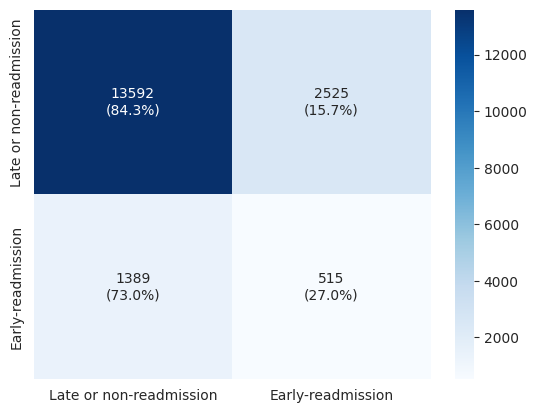

In [231]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

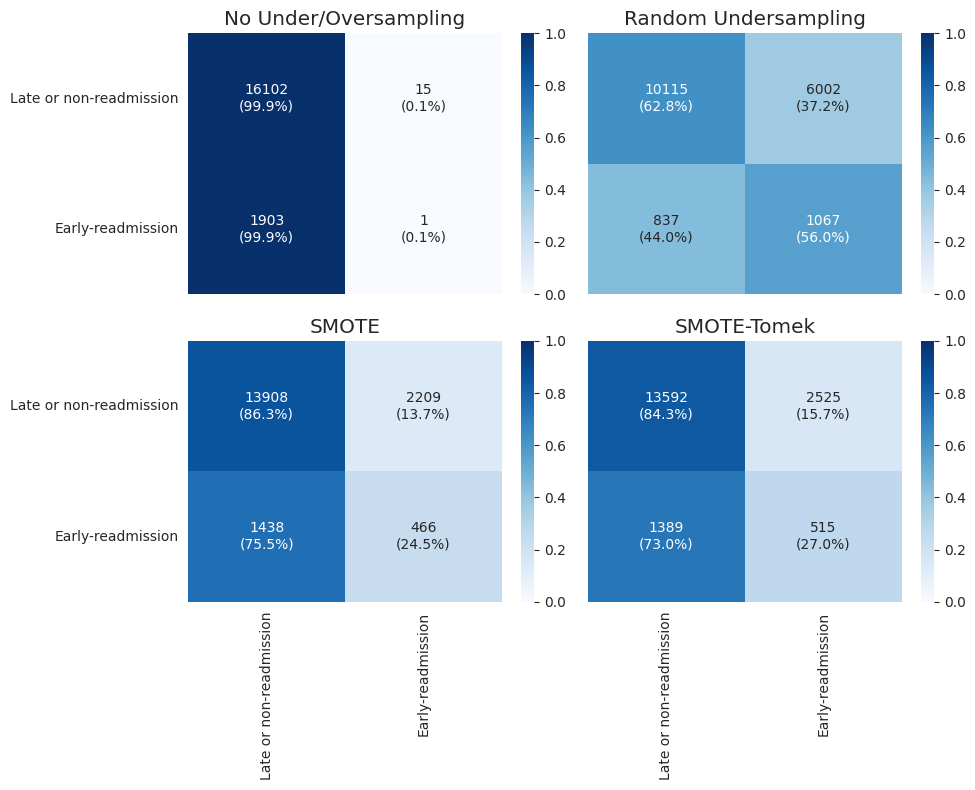

In [232]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [233]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.499797,0.478404,0.472416,0.499797,0.893569
Random Undersampling,0.593999,0.537258,0.492587,0.593999,0.620498
SMOTE,0.553844,0.540250,0.543812,0.553844,0.797625
SMOTE-Tomek,0.556908,0.538345,0.541237,0.556908,0.782809
